<a href="https://colab.research.google.com/github/NaughtyYoda/Web-Log-Analysis/blob/main/Web_Crawling_and_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# data manipulation
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# linear algebra
import numpy as np

# web crawling
from bs4 import BeautifulSoup
import requests

# time series analysis
#!pip install 'statsmodels==0.11.1'
import statsmodels
print(statsmodels.__version__)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# notebook settings
import warnings
warnings.filterwarnings("ignore")

0.11.1


# Crawl Professor citation information

In [2]:
profileCode = 'citations?hl=en&user=dqwjm-0AAAAJ'
gscProfile = requests.get(f"https://scholar.google.com/{profileCode}")

chickenSoup = BeautifulSoup(gscProfile.text, 'html.parser')

create_df = pd.DataFrame()
create_df['year'] = [int(year.text) for year in chickenSoup.find_all('span', {'class': 'gsc_g_t'})]
create_df['Citation'] = [int(year.text) for year in chickenSoup.find_all('span', {'class': 'gsc_g_al'})]
create_df

,year,Citation
0,2003,15
1,2004,34
2,2005,17
3,2006,11
4,2007,33
5,2008,40
6,2009,57
7,2010,68
8,2011,106
9,2012,131


# ARIMA model to predict 2018 to 2020 citations

In [3]:
# split train and test data
train = create_df.loc[create_df['year'] <= 2017, 'Citation'].values
test = create_df.loc[
                     (create_df['year'].between(2018, 2020, inclusive=True)) , 
                     'Citation'
                     ].values

# train ARIMA model
arimaModel = ARIMA(train, order=(1, 1, 1))
arimaModel_fit = arimaModel.fit()
print(arimaModel_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -62.615
Date:                Sat, 26 Jun 2021   AIC                            131.230
Time:                        04:49:49   BIC                            133.148
Sample:                             0   HQIC                           131.053
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9477      0.261      3.626      0.000       0.435       1.460
ma.L1         -0.4796      0.724     -0.663      0.508      -1.898       0.939
sigma2       408.3146    163.656      2.495      0.0

### Predict citations and compute RMSE

In [4]:
history = [x for x in train]
predictions = []
confidence_interval = []
# walk-forward validation
for t, y in zip(range(len(test)), [2018, 2019, 2020]):
  model = ARIMA(history, order=(1, 1, 1))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  history.append(obs)
  print(f'Year : {y}')
  print('predicted=%f, true=%f' % (yhat, obs))
  ci = model_fit.get_forecast().conf_int(0.05) 
  confidence_interval.append(ci[0]) 
  print('95%% Interval: %.3f to %.3f' % (ci[0,0], ci[0,1]))
  print('\n')

Year : 2018
predicted=425.742576, true=454.000000
95% Interval: 386.138 to 465.347


Year : 2019
predicted=508.188331, true=577.000000
95% Interval: 467.927 to 548.450


Year : 2020
predicted=671.913803, true=854.000000
95% Interval: 621.320 to 722.508




In [5]:
# rmse
rmse = mean_squared_error(test, predictions, squared=False)
print('Performance (Test) RMSE: %.3f' % rmse)

Performance (Test) RMSE: 113.562


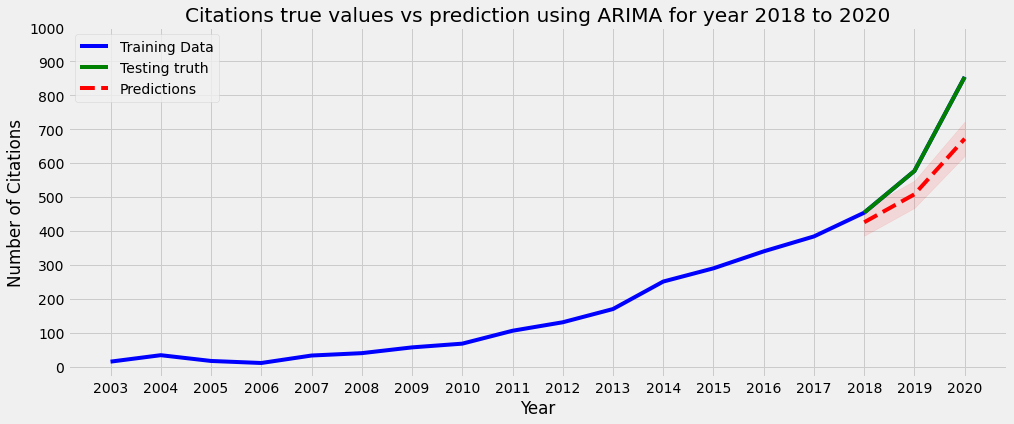

In [6]:
test_years = [2018, 2019, 2020]
with plt.style.context('fivethirtyeight'):
  plt.figure(figsize=(15, 6))
  plt.plot(create_df['year'][:-1], create_df['Citation'][:-1], 'b', label='Training Data')
  plt.plot(test_years, test, 'g', label='Testing truth')
  plt.plot(test_years, predictions, 'r--', label='Predictions')
  plt.fill_between(test_years,
                  np.array(confidence_interval)[:,0], np.array(confidence_interval)[:,1],
                  alpha=0.1, color='r')
  plt.xticks(np.arange(2003, 2021))
  plt.yticks(np.arange(0, 1001, 100))
  plt.xlabel('Year')
  plt.ylabel('Number of Citations')
  plt.title('Citations true values vs prediction using ARIMA for year 2018 to 2020')
  plt.legend()

# Conduct the Grid Search with paramter selection and then predict the 2021 and 2022

### Grid Search

In [7]:
p = list(range(1,3))
q = list(range(1,3))
d = list(range(1,3))
RMSE = []
PARAMETER = []
predictions = []
# walk-forward validation
for i1 in p:
  for i2 in q:
    for i3 in d:
      for t in range(len(test)):
        model = ARIMA(history, order=(i1,i3,i2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
      rmse = mean_squared_error(test, predictions, squared=False)
      history = [x for x in train]
      predictions = list()  
      RMSE.append(rmse)
      PARAMETER.append(f'p={i1}, d={i3}, q={i2}')

In [8]:
Results = pd.DataFrame({'RMSE':RMSE,'Parameter':PARAMETER})
Results

,RMSE,Parameter
0,449.100894,"p=1, d=1, q=1"
1,108.918749,"p=1, d=2, q=1"
2,135.980108,"p=1, d=1, q=2"
3,109.953540,"p=1, d=2, q=2"
4,105.555765,"p=2, d=1, q=1"
5,117.427055,"p=2, d=2, q=1"
6,114.695965,"p=2, d=1, q=2"
7,115.462290,"p=2, d=2, q=2"


In [9]:
# best parameters
Results[Results.RMSE == Results.RMSE.min()]

,RMSE,Parameter
4,105.555765,"p=2, d=1, q=1"


### TRAIN With Best Parameter Set with data up to 2020 and Predict the 2021 and 2022

In [10]:
train = create_df['Citation'].values[:-1]

arimaModel = ARIMA(train, order=(2, 1, 1))
arimaModel_fit = arimaModel.fit()
print(arimaModel_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   18
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -89.841
Date:                Sat, 26 Jun 2021   AIC                            187.682
Time:                        04:49:51   BIC                            191.015
Sample:                             0   HQIC                           188.013
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5678      2.178      0.720      0.472      -2.700       5.836
ar.L2         -0.6097      2.208     -0.276      0.782      -4.937       3.717
ma.L1         -0.1960      2.181     -0.090      0.9

In [11]:
# predict citations for 2021 and 2022
predicted = arimaModel_fit.get_forecast(2).predicted_mean
ci = arimaModel_fit.get_forecast(2).conf_int(0.05)
forecasted_years = [2021, 2022]
for i, y in zip(predicted, forecasted_years):
  print(f'Predicted value for year {y}: {round(i)}')

Predicted value for year 2021: 1187
Predicted value for year 2022: 1539


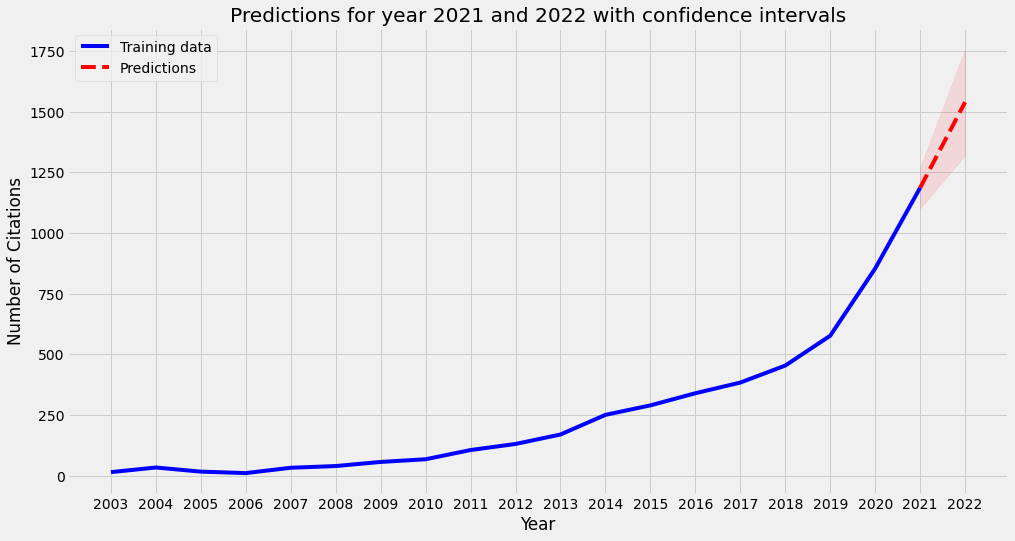

In [12]:
# Plot the points and the prediction with its confidence interval
x = list(create_df['year'][:-1])
x.append(forecasted_years[0])
y = list(create_df['Citation'][:-1])
y.append(predicted[0])
with plt.style.context('fivethirtyeight'):
  plt.figure(figsize=(15, 8))
  plt.plot(x, y, 'b-', label='Training data')
  plt.plot(forecasted_years, predicted, 'r--', label='Predictions')
  plt.fill_between(forecasted_years,
                  np.array(ci)[:,0], np.array(ci)[:,1],
                  alpha=0.1, color='r')
  plt.xticks(np.arange(2003, 2023, 1))
  plt.legend(loc='upper left')
  plt.xlabel('Year')
  plt.ylabel('Number of Citations')
  plt.title('Predictions for year 2021 and 2022 with confidence intervals')